In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.43


In [92]:
from sklearn.externals import joblib
import pickle

In [55]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
from azureml.train.sklearn import SKLearn

import os
import urllib.request
import shutil

In [5]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep = '\t')

azure-ml-experiments	northeurope	pedro-test


### Create an experiment

In [6]:
experiment_name = 'test-azureml-sklearn-mnist'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

### Create or attach an existing compute resource 

Here Azure ML will create a VM to run the code in the cloud

In [8]:
# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "azure-ml-cpu")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

In [9]:
compute_name

'azure-ml-cpu'

In [10]:
# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")

In [11]:
vm_size

'STANDARD_D2_V2'

In [15]:
if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = vm_size,
                                                                min_nodes = compute_min_nodes,
                                                                max_nodes = compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(ws, compute_name, provisioning_config)

    # can poll for a minimum number of nodes and for a specific timeout.
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

     # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

creating a new compute target...
Creating
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2019-06-24T16:23:57.586000+00:00', 'errors': None, 'creationTime': '2019-06-24T16:23:41.877766+00:00', 'modifiedTime': '2019-06-24T16:23:57.760924+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_D2_V2'}


You now have the necessary packages and compute resources to train a model in the cloud.

###  Bring the data in

Downloading MNIST dataset from the web

In [18]:
data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok = True)

urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', filename=os.path.join(data_folder, 'train-images.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', filename=os.path.join(data_folder, 'train-labels.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', filename=os.path.join(data_folder, 'test-images.gz'))
urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', filename=os.path.join(data_folder, 'test-labels.gz'))

('/Users/psfriso/Code/azure_settings/azure_ml_tutorial/data/test-labels.gz',
 <http.client.HTTPMessage at 0x114a5c358>)

In [19]:
!ls

Azure ML SDK Get Started.ipynb data
MNIST example.ipynb            outputs


In [20]:
!ls data/

test-images.gz  test-labels.gz  train-images.gz train-labels.gz


In [21]:
from utils import load_data

In [23]:
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the model converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_train = load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)

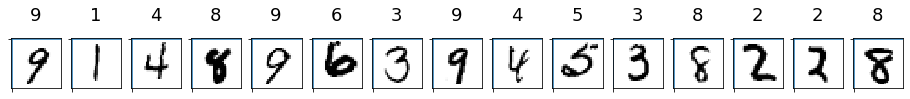

In [26]:
# now let's show some randomly chosen images from the traininng set.
count = 0
sample_size = 15
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x=10, y=-10, s=y_train[i], fontsize=18)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.Greys)

###  Upload the data to the cloud

In [27]:
ds = ws.get_default_datastore()

In [47]:
print(ds.datastore_type, ds.account_name, ds.container_name)

AzureBlob azuremlestorage9451e43f9 azureml-blobstore-71e38e68-7b34-4a4e-97c2-09d047576363


In [108]:
data_folder

'/Users/psfriso/Code/azure_settings/azure_ml_tutorial/data'

In [49]:
ds.upload(src_dir=data_folder, target_path='mnist', overwrite=True, show_progress=True)

Uploading /Users/psfriso/Code/azure_settings/azure_ml_tutorial/data/test-images.gz
Uploading /Users/psfriso/Code/azure_settings/azure_ml_tutorial/data/test-labels.gz
Uploading /Users/psfriso/Code/azure_settings/azure_ml_tutorial/data/train-images.gz
Uploading /Users/psfriso/Code/azure_settings/azure_ml_tutorial/data/train-labels.gz
Uploaded /Users/psfriso/Code/azure_settings/azure_ml_tutorial/data/test-labels.gz, 1 files out of an estimated total of 4
Uploaded /Users/psfriso/Code/azure_settings/azure_ml_tutorial/data/train-labels.gz, 2 files out of an estimated total of 4
Uploaded /Users/psfriso/Code/azure_settings/azure_ml_tutorial/data/test-images.gz, 3 files out of an estimated total of 4
Uploaded /Users/psfriso/Code/azure_settings/azure_ml_tutorial/data/train-images.gz, 4 files out of an estimated total of 4


$AZUREML_DATAREFERENCE_40403fd059bf4674a8f510f82bc45371

### Train on a remote cluster

We need to create a local directory to pass the code from the local computer to the remote resource

In [50]:
script_folder  = os.path.join(os.getcwd(), "sklearn-mnist")
os.makedirs(script_folder, exist_ok=True)

#### Create a training script

In [51]:
%%writefile $script_folder/train.py

import argparse
import os
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

from azureml.core import Run
from utils import load_data

# let user feed in 2 parameters, the location of the data files (from datastore), 
# and the regularization rate of the logistic regression model
parser = argparse.ArgumentParser()
parser.add_argument('--data-folder', type=str, dest='data_folder', help='data folder mounting point')
parser.add_argument('--regularization', type=float, dest='reg', default=0.01, help='regularization rate')
args = parser.parse_args()

data_folder = args.data_folder
print('Data folder:', data_folder)

# load train and test set into numpy arrays
# note we scale the pixel intensity values to 0-1 (by dividing it with 255.0) so the model can converge faster.
X_train = load_data(os.path.join(data_folder, 'train-images.gz'), False) / 255.0
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_train = load_data(os.path.join(data_folder, 'train-labels.gz'), True).reshape(-1)
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, sep = '\n')

# get hold of the current run
run = Run.get_context()

print('Train a logistic regression model with regularization rate of', args.reg)
clf = LogisticRegression(C=1.0/args.reg, solver="liblinear", multi_class="auto", random_state=42)
clf.fit(X_train, y_train)

print('Predict the test set')
y_hat = clf.predict(X_test)

# calculate accuracy on the prediction
acc = np.average(y_hat == y_test)
print('Accuracy is', acc)

run.log('regularization rate', np.float(args.reg))
run.log('accuracy', np.float(acc))

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record
joblib.dump(value=clf, filename='outputs/sklearn_mnist_model.pkl')

Writing /Users/psfriso/Code/azure_settings/azure_ml_tutorial/sklearn-mnist/train.py


Copying the `utils.py` module into the scripts folder that is going to be uploaded to the remote cluster

In [53]:
shutil.copy('utils.py', script_folder)

'/Users/psfriso/Code/azure_settings/azure_ml_tutorial/sklearn-mnist/utils.py'

### Creating an estimator

Still I need to find out what an estimator is. But this is only valid to use SKlearn estimators

In [56]:
script_params = {
    '--data-folder': ds.path('mnist').as_mount(),
    '--regularization': 0.5
}

est = SKLearn(source_directory=script_folder,
                script_params=script_params,
                compute_target=compute_target,
                entry_script='train.py')

### Submit the job to the cluster

In [65]:
run = exp.submit(config=est)
run

Experiment,Id,Type,Status,Details Page,Docs Page
test-azureml-sklearn-mnist,test-azureml-sklearn-mnist_1561458692_359c571d,azureml.scriptrun,Queued,Link to Azure Portal,Link to Documentation


The code run succesfully

The estimator replticates the enviroment where is running apparently. I don't see the sklearn module being loaded, need to invistigate further.

In [74]:
est.conda_dependencies.save_to_file('.')

'.azureml/auto_conda_dependencies.yml'

In [76]:
!cat .azureml/auto_conda_dependencies.yml







name: project_environment
dependencies:


- python=3.6.2

- pip:

  - azureml-defaults

channels:
- conda-forge


In [77]:
# run.wait_for_completion(show_output=False) # specify True for a verbose log

In [79]:
run.get_metrics()

{'regularization rate': 0.5, 'accuracy': 0.9193}

In [80]:
run.get_file_names()

['azureml-logs/55_batchai_execution.txt',
 'azureml-logs/55_batchai_stdout-job_post.txt',
 'azureml-logs/55_batchai_stdout-job_prep.txt',
 'azureml-logs/55_batchai_stdout.txt',
 'azureml-logs/70_driver_log.txt',
 'azureml-logs/driver_log.txt',
 'logs/azureml/129_azureml.log',
 'logs/azureml/azureml.log',
 'outputs/sklearn_mnist_model.pkl']

Make the model publically available

In [81]:
# register model
model = run.register_model(model_name='sklearn_mnist', model_path='outputs/sklearn_mnist_model.pkl')
print(model.name, model.id, model.version, sep = '\t')

sklearn_mnist	sklearn_mnist:1	1


## Part 2: Deploy the model

In [82]:
from azureml.core.model import Model

In [83]:
# ws = Workspace.from_config()
# the workspace is already loaded

In [84]:
model = Model(ws, 'sklearn_mnist')

In [85]:
model.download(target_dir=os.getcwd(), exist_ok=True)

'/Users/psfriso/Code/azure_settings/azure_ml_tutorial/sklearn_mnist_model.pkl'

In [86]:
# verify the downloaded model file
file_path = os.path.join(os.getcwd(), "sklearn_mnist_model.pkl")

In [88]:
os.stat(file_path)

os.stat_result(st_mode=33188, st_ino=9294267, st_dev=16777220, st_nlink=1, st_uid=501, st_gid=20, st_size=63684, st_atime=1561464347, st_mtime=1561464346, st_ctime=1561464346)

### Test the model locally 

In [90]:
data_folder = os.path.join(os.getcwd(), 'data')
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(os.path.join(data_folder, 'test-images.gz'), False) / 255.0
y_test = load_data(os.path.join(data_folder, 'test-labels.gz'), True).reshape(-1)

In [93]:
clf = joblib.load( os.path.join(os.getcwd(), 'sklearn_mnist_model.pkl'))
y_hat = clf.predict(X_test)

/Users/psfriso/anaconda3/envs/azure_ml/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [95]:
np.mean(y_hat == y_test)

0.9193

### Deploy

Script to run the model?

In [96]:
%%writefile score.py
import json
import numpy as np
import os
import pickle
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression

from azureml.core.model import Model

def init():
    global model
    # retrieve the path to the model file using the model name
    model_path = Model.get_model_path('sklearn_mnist')
    model = joblib.load(model_path)

def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    # make prediction
    y_hat = model.predict(data)
    # you can return any data type as long as it is JSON-serializable
    return y_hat.tolist()

Writing score.py


In [103]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_conda_package("scikit-learn")

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

In [104]:
with open("myenv.yml","r") as f:
    print(f.read())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
    # Required packages for AzureML execution, history, and data preparation.
  - azureml-defaults

- scikit-learn
channels:
- conda-forge



Configuration file?

In [105]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={"data": "MNIST",  "method" : "sklearn"}, 
                                               description='Predict MNIST with sklearn')

### Actual deployment

In [106]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.image import ContainerImage

# configure the image
image_config = ContainerImage.image_configuration(execution_script="score.py", 
                                                  runtime="python", 
                                                  conda_file="myenv.yml")

service = Webservice.deploy_from_model(workspace=ws,
                                       name='sklearn-mnist-svc',
                                       deployment_config=aciconfig,
                                       models=[model],
                                       image_config=image_config)

service.wait_for_deployment(show_output=True)

Creating image
Running.
NotStarted.....................................................
Succeeded
Image creation operation finished for image sklearn-mnist-svc:1, operation "Succeeded"
Creating service
Failed

ERROR - Service deployment polling reached non-successful terminal state, current service state: Transitioning
Error:
{
  "code": "RequestDisallowedByPolicy",
  "statusCode": 403,
  "message": "ACI Service request failed. Reason: Resource 'sklearn-mnist-svc' was disallowed by policy. Policy identifiers: '[{\"policyAssignment\":{\"name\":\"Mandatory\",\"id\":\"/providers/Microsoft.Management/managementGroups/f55b1f7d-7a7f-49e4-9b90-55218aad89f8/providers/Microsoft.Authorization/policyAssignments/9978978c349a4e128d18fe76\"},\"policyDefinition\":{\"name\":\"Allowed locations\",\"id\":\"/providers/Microsoft.Authorization/policyDefinitions/e56962a6-4747-49cd-b67b-bf8b01975c4c\"},\"policySetDefinition\":{\"name\":\"Mandatory\",\"id\":\"/providers/Microsoft.Management/managementgroups/f55b1f7d-7a7f-49e4-9b90-55218aad89f8/providers/Microsoft.Authorization/policySetDefinitions/Important\"}}]'.."
}

ERROR - Service deployment polling reached non-successful terminal state, current service state: 

WebserviceException: Service deployment polling reached non-successful terminal state, current service state: Transitioning
Error:
{
  "code": "RequestDisallowedByPolicy",
  "statusCode": 403,
  "message": "ACI Service request failed. Reason: Resource 'sklearn-mnist-svc' was disallowed by policy. Policy identifiers: '[{\"policyAssignment\":{\"name\":\"Mandatory\",\"id\":\"/providers/Microsoft.Management/managementGroups/f55b1f7d-7a7f-49e4-9b90-55218aad89f8/providers/Microsoft.Authorization/policyAssignments/9978978c349a4e128d18fe76\"},\"policyDefinition\":{\"name\":\"Allowed locations\",\"id\":\"/providers/Microsoft.Authorization/policyDefinitions/e56962a6-4747-49cd-b67b-bf8b01975c4c\"},\"policySetDefinition\":{\"name\":\"Mandatory\",\"id\":\"/providers/Microsoft.Management/managementgroups/f55b1f7d-7a7f-49e4-9b90-55218aad89f8/providers/Microsoft.Authorization/policySetDefinitions/Important\"}}]'.."
}

In [107]:
print(service.scoring_uri)

None
